## Installation

If you are using Colab, we need to install some extra package as follows:

In [1]:
%pip install mrcfile tensorflow-graphics tensorflow_similarity numpy-quaternion -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


You can download the existing dataset and settting the directory for the codebase as follows:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE = "/content/drive/MyDrive/protein-reconstruction/data/data/ribsome_synthetic/"
DATASET_PATH = ""

In [4]:
ROOT_DIR = '/content/drive/MyDrive/protein-reconstruction/'

In [5]:
!cp {DRIVE}X_ctf.npy .
!cp {DRIVE}y_ctf.npy .
!cp {DRIVE}indices.npz .

> If you're executing this on a local machine, you should directly specify the path to where your dataset resides by setting the `DATASET_PATH`. For instance, if your dataset is located in the directory `/home/username/cryoforum/data/beta-gal_synthetic/`, you would assign this path to the variable like so: `DATASET_PATH = "/home/username/cryoforum/data/beta-gal_synthetic/"`.

### Read data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import mrcfile

sys.path.append(ROOT_DIR)

# From the code base
from cryoem.conversions import quaternion2euler, euler2quaternion, d_q, SO3_to_s2s2, s2s2_to_SO3, matrix2quaternion, quaternion2matrix, euler2matrix, matrix2euler, euler2matrix
from cryoem.helpers import train_val_test_split, projections_preprocessing, AttrDict, window_mask
from cryoem.layers import BlurLayer, BlurLayer2, GeneralizedMeanPooling2D2
from cryoem.utils_ascep import visualise_images, Starfile
from cryoem.losses import cosine_distance, cos_dist_output_shape, d_q2, d_q3, cus_loss, cus_loss_function, cus_mae, cus_loss2
from cryoem.visualize import draw_bingham, BinghamDistribution
from cryoem.uncertainty import max_dispersion_coeff, sum_bingham_dispersion_coeff, first_eig_gap, wigner_log_likelihood_measure

# From the tensorflow
import tensorflow as tf
from tensorflow_similarity.layers import GeneralizedMeanPooling2D
from tensorflow import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 190116665929340502
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16918908624733966196
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
config = dict(
    X_file = "X_ctf.npy",
    y_file = "y_ctf.npy",
    image_width = 128,
    image_height = 128,
    model = 'vgg_like',
    model_name = 'model_qcqp_ribosome',
    BlurType = 1,
    window = True,
    norm = True
)

The first step is to read the images and setting the hyperparameters for the project. We have created a configuration structure using custom `AttrDict` class so that developers can easily adjust the configurations:

The meaning of each parameters is summarized as follows:

- **`X_file`**: The 2D Cryo-EM images.
- **`y_file`**: The ground truth Euler angles in radians.
- **`image_width`**: The width of the image.
- **`image_height`**: The height of the image.
- **`batch_size`**: The batch size use during training. For contrastive learning a larger batch size is recommended.
- **`model`**: The model we would like to use, currently no use since we use vgg-like network as our backbone.
- **`model_name`**: The name of the trained model that is used when we store the model into disk.
- **`BlurType`**: 0,1,2. 0 means no preprocessing layer is added. 1 means use low pass filter preprocessing layer. 2 means use Gaussian blurring preprocessing layer.
- **`window`**: If set to `True`, we will put a mask on the images to mitigate background noise before training.
- **`norm`**: If set to `True`, we will standardize the images before training.



In [8]:
config = AttrDict(config)
config

{'X_file': 'X_ctf.npy',
 'y_file': 'y_ctf.npy',
 'image_width': 128,
 'image_height': 128,
 'model': 'vgg_like',
 'model_name': 'model_qcqp_ribosome',
 'BlurType': 1,
 'window': True,
 'norm': True}

We load the Cryo-EM images and the ground truth angle first. Then, we convert the angles into 3D Rotation matrix so that we can ease the computation of loss between different angle representation.

In [9]:
X = np.load(DATASET_PATH+config.X_file)
y = np.load(DATASET_PATH+config.y_file)
y = euler2matrix(y)
y = y.numpy()

We load the training, validation and testing split for better reprocudibility. You can also omit the `file_name` to generate different split for differnt dataset.

In [10]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(X.shape[0]), file_name=DATASET_PATH+"indices.npz")
len(train_idx), len(val_idx), len(test_idx), X.shape, y.shape

(2512, 838, 1650, (5000, 128, 128, 1), (5000, 3, 3))

Before inference, we can preprocess the images as follows:

In [11]:
if config.window:
  X = X.squeeze()
  X = X*window_mask(config.image_height, 0.85, 0.99)
  X = np.expand_dims(X, -1)

if config.norm:
  X = X.squeeze()
  norm  = [np.mean(X), np.std(X)]
  X = (X - norm[0])/norm[1]
  X = np.expand_dims(X, -1)

Visualize the preprocessed images:

In [12]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

### Read Model Checkpoint

Here, we can store the trained model to disk or read pretrained model back:

In [13]:
# Load pretrained model
!cp /content/drive/MyDrive/protein-reconstruction/models/model_qcqp_ribosome2.h5 /content/model_qcqp_ribosome2.h5

In [14]:
# put correct filename
model_filename = "model_qcqp_ribosome2.h5"  # The pretrained model

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename, compile=False, custom_objects={"BlurLayer": BlurLayer})
# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 cnn (Functional)            [(None, 4, 4),               2018157   ['input_3[0][0]',             
                              None]                       8          'input_4[0][0]']             
                                                                                                  
 distance (Lambda)           (None,)                      0         ['cnn[0][1]',             

## Analysis

### Visualize the dispersion

We now get the trained model and make inference on train/validation/test split.

In [15]:
cnn = model.layers[-2]

In [16]:
q_pred_train = cnn.predict(X[train_idx])[1]
q_pred_val = cnn.predict(X[val_idx])[1]
q_pred_test = cnn.predict(X[test_idx])[1]

52/52 [==============================] - 3s 51ms/step


In [17]:
#vgg
c1 = d_q(q_pred_train, matrix2quaternion(y[train_idx]))
c2 = d_q(q_pred_val, matrix2quaternion(y[val_idx]))
c3 = d_q(q_pred_test, matrix2quaternion(y[test_idx]))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.015099191575801515,
 0.06926385889149395,
 0.07647633919523,
 0.015842862310145832,
 0.08039809471898181,
 0.08787168552244912)

In [18]:
A_train = cnn.predict(X[train_idx])[0]
A_val = cnn.predict(X[val_idx])[0]
A_test = cnn.predict(X[test_idx])[0]

52/52 [==============================] - 2s 41ms/step


We calculate the uncertainty statistics here:

In [19]:
lls = [max_dispersion_coeff(A_test), max_dispersion_coeff(A_train)]
lls2 = [sum_bingham_dispersion_coeff(A_test), sum_bingham_dispersion_coeff(A_train)]
lls3 = [first_eig_gap(A_test), first_eig_gap(A_train)]
lls4 = [wigner_log_likelihood_measure(A_test), wigner_log_likelihood_measure(A_train)]
errors = [d_q(q_pred_test, matrix2quaternion(y[test_idx])), d_q(q_pred_train, matrix2quaternion(y[train_idx]))]
df = pd.DataFrame([errors[0].numpy(), lls[0], lls2[0], lls3[0], lls4[0]]).T
df.columns = ['error', 'max', 'trace', 'gap', 'likelihood']
df

,error,max,trace,gap,likelihood
0,0.073883,-99.005707,-553.126709,99.005707,-1.864119e+04
1,0.052869,-108.880615,-507.366470,108.880615,-1.960609e+04
2,0.169524,-137.939484,-863.399384,137.939484,-5.478075e+04
3,0.126574,-178.951691,-889.244843,178.951691,-9.165317e+04
4,0.050015,-156.206161,-832.241058,156.206161,-9.876853e+04
...,...,...,...,...,...
1645,0.020431,-352.248627,-2518.436401,352.248627,-1.150925e+06
1646,0.014155,-147.552505,-729.223846,147.552505,-3.509070e+04
1647,0.046376,-288.633514,-1501.149963,288.633514,-3.079937e+05
1648,0.009824,-319.214172,-1610.580627,319.214172,-3.117748e+05


Here, we select three different data points with differnt dispersions:

In [27]:
metric = 'max'

q1_value = df[metric].quantile(0.01)
q2_value = df[metric].quantile(0.50)
q3_value = df[metric].quantile(0.99)

q1_index = df[metric].sub(q1_value).abs().idxmin()
q2_index = df[metric].sub(q2_value).abs().idxmin()
q3_index = df[metric].sub(q3_value).abs().idxmin()

In [28]:
q1_value, q2_value, q3_value

(-354.91776885986326, -143.69322204589844, -40.38526260375977)

In [29]:
df.iloc[q1_index, 0], df.iloc[q2_index, 0], df.iloc[q3_index, 0]

(0.048017316144620806, 0.11864035895075177, 0.1471365570609108)

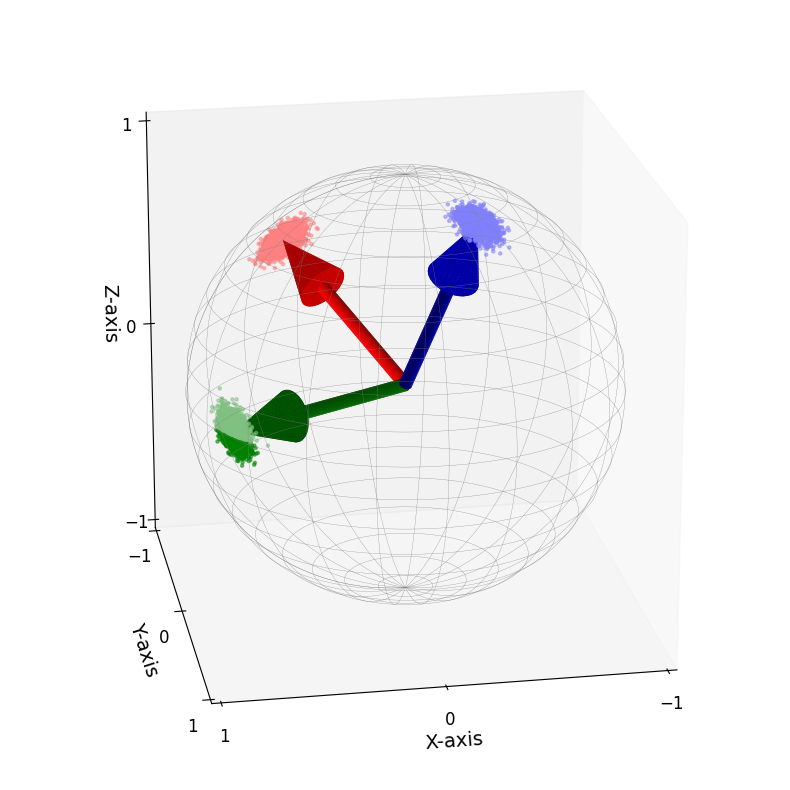

In [30]:
bd = BinghamDistribution(A=A_test[q1_index])
draw_bingham(bd, None, num_samples=2000)

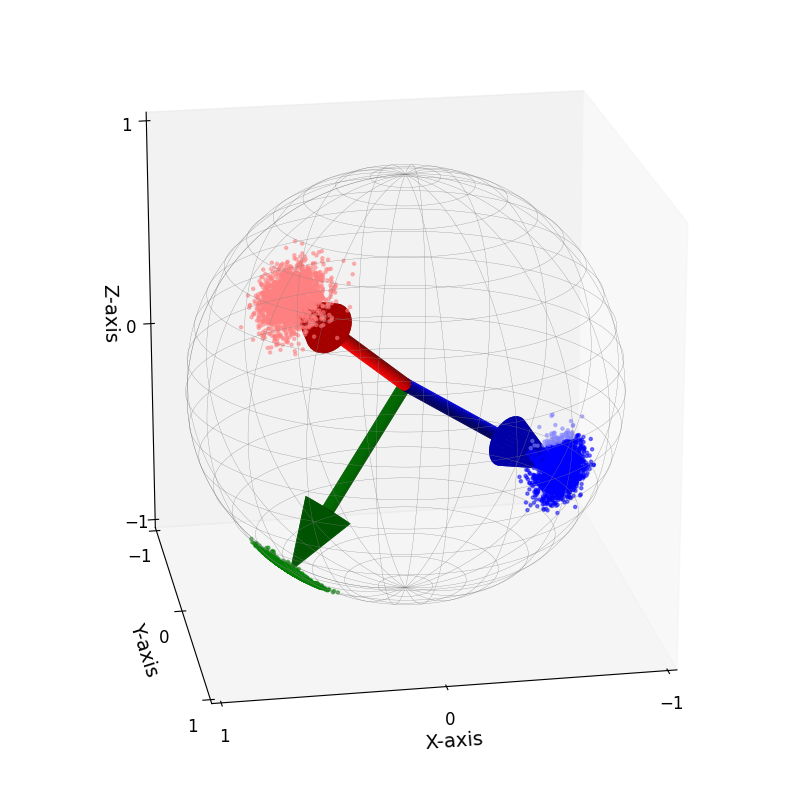

In [31]:
bd = BinghamDistribution(A=A_test[q2_index])
draw_bingham(bd, None, num_samples=2000)

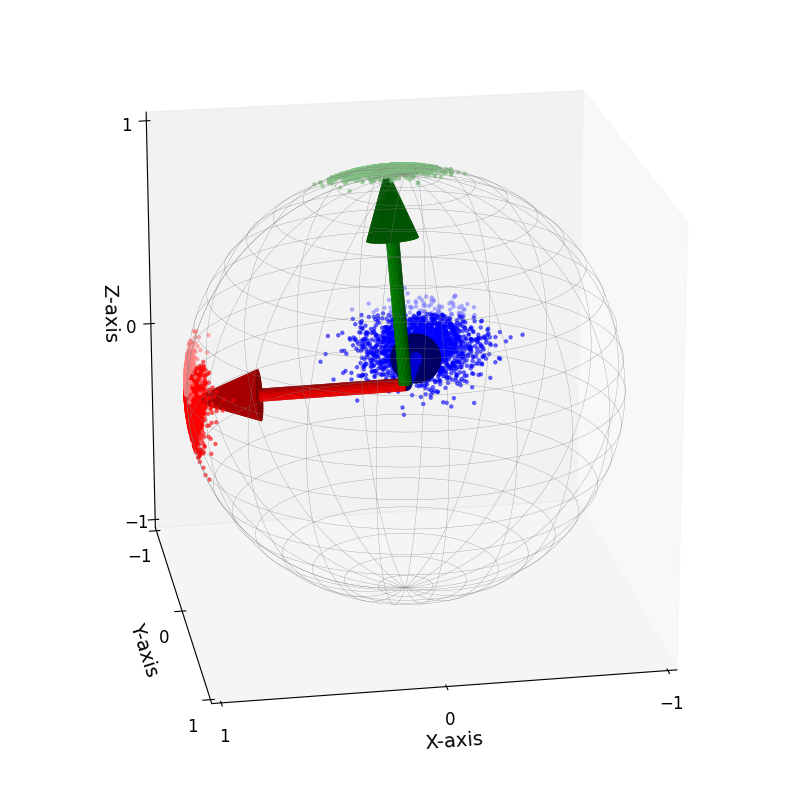

In [32]:
bd = BinghamDistribution(A=A_test[q3_index])
draw_bingham(bd, None, num_samples=2000)

We suggest to visulalize the data with median dispersion value to give an insight on the dispersion of the dataset:

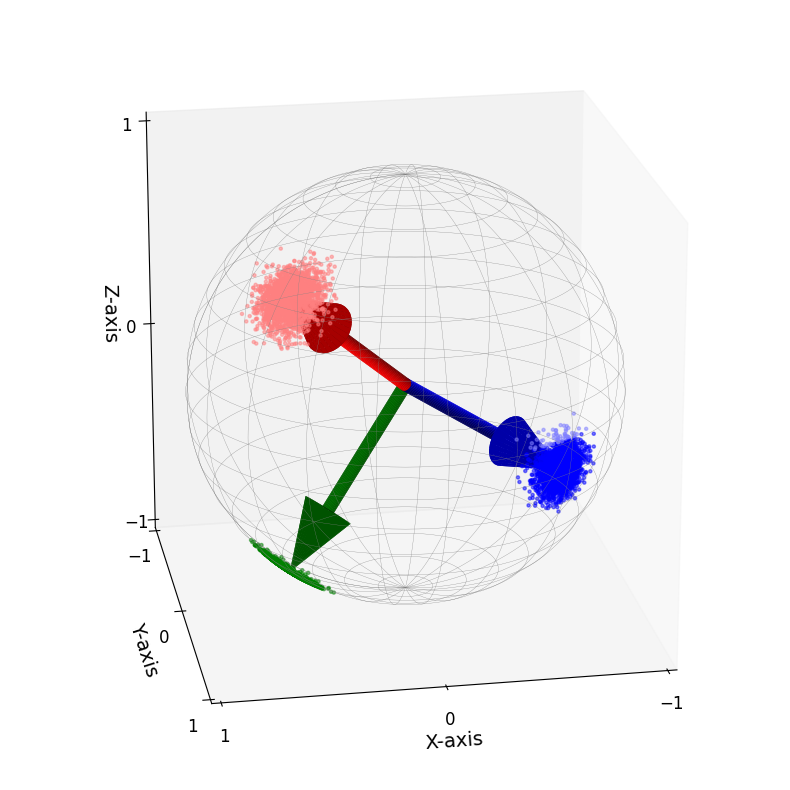

In [33]:
bd = BinghamDistribution(A=A_test[q2_index])
draw_bingham(bd, None, num_samples=2000)